# Rondas 1 y 2



### 1. Medida de Riesgo
* definir variables target
* preprocesar variables 
* calcular indice de riesgo
* definir etiquetas

### 2. Modelo
* gridsearch
* entrenar regresion
* ROC
* Matriz de Confusion
* Reporte de clasificacion
* Otros analisis (variables y quintiles)


In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc, accuracy_score,f1_score
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, KFold
import statsmodels.api as sm
import time

#%pylab inline

pd.set_option('display.float_format', lambda x: '%.3f' % x)

#formato de visualizaciones


In [2]:
def risk_calculation(pond, df_with_dummies, ronda, var_socioec, var_salud, var_antrp):
    if pond == 'standar':
        var_target = var_socioec + var_salud + var_antrp

        pond_socioec  = 1/len(var_socioec)
        pond_salud = 1/len(var_salud)
        pond_antrp = 1/len(var_antrp)

        data_ronda = df_with_dummies[df_with_dummies.ronda == ronda].sort_values(by = 'childid')

        min_max_scaler = MinMaxScaler() 
        data_ronda.loc[:,var_target] = min_max_scaler.fit_transform(data_ronda.loc[:,var_target])

        score_salud = (data_ronda.loc[:,var_salud] * pond_salud).sum(axis=1)
        score_antrp = (data_ronda.loc[:,var_antrp] * pond_antrp).sum(axis=1)
        score_socioec = (data_ronda.loc[:,var_socioec] * pond_socioec).sum(axis=1)
        
        score_final = (1/3) * score_salud + (1/3) * score_antrp + (1/3) * score_socioec 

        data_ronda["risk"] = score_final
        data_ronda["risk"] = np.where(data_ronda.deceased == 1, 1, data_ronda.risk)
    else:
        print("need to adjust manually")
    
    return data_ronda


In [3]:




def label_observation(y_prob, prop, classes = None):
    if classes == 'binary':
        cut = round((1-prop)/0.1)
        y_pred = pd.DataFrame(y_prob, columns = ['y_test_prob'])
        y_pred = pd.qcut(y_pred.y_test_prob, 10, labels = False, duplicates = 'drop')
        y_pred = np.where(y_pred >= cut,1,0)
    else:
        print('modify function')
    return y_pred


            

In [4]:
def roc_curve_plot(y_test, y_prob, data_set = None):
    fpr_log,tpr_log,thr_log = roc_curve(y_test, y_prob)
    df = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))
    plt.axis([0, 1.01, 0, 1.01])
    plt.xlabel('1 - Specificty')
    plt.ylabel('TPR / Sensitivity')
    plt.title('ROC Curve')
    plt.plot(df['fpr'],df['tpr'])
    plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
    plt.show() 
    
    if data_set == 'train':
        return print('AUC train =', auc(fpr_log, tpr_log))
    elif data_set == 'test':
        return print('AUC test =', auc(fpr_log, tpr_log))
    else:
        return print('AUC =', auc(fpr_log, tpr_log))
        

## Carga de dataset

In [5]:
# importo los datos
df = pd.read_csv("Desktop/TESIS/df_final.csv", na_values=' ')
df.rename(columns={'round': 'ronda'}, inplace=True)
df.head()

,childid,yc,ronda,inround,panel12345,deceased,dint,placeid,clustid,typesite,...,maths_raw,ppvt_raw,rawscre,reading_raw,sppvt_raw,srawscre,score_cog,rscorelang_cog,rscorelang_ppvt,score_ppvt
0,PE011001,1,1,1,1,NaN,9/2/2002,PE01C01,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PE011001,1,2,1,1,NaN,3/26/2007,PE01C01,1.000,1.000,...,NaN,NaN,22.000,NaN,NaN,NaN,9.000,305.212,280.317,22.000
2,PE011001,1,3,1,1,NaN,8/10/2009,PE01C01,1.000,1.000,...,21.000,80.000,80.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PE011001,1,4,1,1,NaN,8/8/2013,PE01C01,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PE011001,1,5,1,1,NaN,8/11/2016,PE01C01,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Modificaciones y transformaciones de variables antes de dividir por ronda

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# modifico las variables para el target para que a mayor valor, mayor riesgo
# CATEGORICAS

df.chsex = np.where(df.chsex == 2,0,1) 

df.headsex = np.where(df.headsex == 2,0,1) 

df.caresex = np.where(df.caresex == 2,0,1) 

df['chhrel_mod'] = np.where(df.chhrel == 3,1,0)  # marco solo el caso "Worse", no el de "Same" o "Better"



df['bmi_cat'] = 0
df.loc[df.bmi < 18.5 , "bmi_cat"] = 2
df.loc[(df.bmi >= 18.5) & (df.bmi <22), "bmi_cat"] = 0
df.loc[(df.bmi >= 22) & (df.bmi <24.9) , "bmi_cat"] = 1
df.loc[(df.bmi >= 24.9) & (df.bmi <29.9) , "bmi_cat"] = 2
df.loc[(df.bmi >=29.9) , "bmi_cat"] = 3

#pd.cut(x=df['bmi'], bins=[0, 18.5, 22, 24.9, 29.9, 500 ],ordered=False,
#                     labels=[2, 0, 1, 2, 3])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# modifico las variables para el target para que a mayor valor, mayor riesgo
# CONTINUAS

df["wi"] = ((df["wi"] - 1) * -1)
df["hq"] = ((df["hq"] - 1) * -1)
df["cd"] = ((df["cd"] - 1) * -1)
df["sv"] = ((df["sv"] - 1) * -1)

df.loc[df["wi"].isna(),'wi'] = 1
df.loc[df["hq"].isna(),'hq'] = 1
df.loc[df["cd"].isna(),'cd'] = 1
df.loc[df["sv"].isna(),'sv'] = 1

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Quito variables y hago arreglos finales en todo el dataset

# Paso a dummy variables PREDICTORAS que son NO ordinales.
dummie_list = ["headrel","carerel","carehead","entype","chrephealth4",'chdisscale',"region"]
dummies = pd.concat([pd.get_dummies(df[col]) for col in dummie_list], axis=1, keys=dummie_list)
df_with_dummies = pd.concat([df,dummies],axis = 1)

# paso a int la unica variable que quedó en formato "objeto"
df.hospital.replace(['Yes', 'No'],[0,1], inplace=True)

## Definicion de variables para cada ronda
Se mantienen separadas por si en algun futuro alguna ronda es modificada independientemente de las demas

In [7]:

# Para cada eje (salud, socioeconomico, etc)
# definimos las variables que determinan si el niño estuvo expuesto a una situacion de riesgo o no
# la idea es hacerlo para cada ronda

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# RONDA 1

var_r1_socioec_cat = []
var_r1_socioec_cont  = ['wi',"hq","cd","sv"]
var_r1_socioec = var_r1_socioec_cont + var_r1_socioec_cat

var_r1_salud_cat = ["chhrel","chmightdie","deceased"]
var_r1_salud_cont = []
var_r1_salud = var_r1_salud_cat + var_r1_salud_cont

var_r1_familia_cat = []
var_r1_familia_cont = []
var_r1_familia = var_r1_familia_cat + var_r1_familia_cont

var_r1_antrp_cat = ['stunting',"bmi_cat"]
var_r1_antrp_cont = []
var_r1_antrp = var_r1_antrp_cat + var_r1_antrp_cont

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# RONDA 2

var_r2_socioec_cat = []
var_r2_socioec_cont  = ['wi',"hq","cd","sv"]
var_r2_socioec = var_r2_socioec_cont + var_r2_socioec_cat

var_r2_salud_cat = ["chhrel","chmightdie","chillness","deceased","chhrel_mod"]
var_r2_salud_cont = []
var_r2_salud = var_r2_salud_cat + var_r2_salud_cont

var_r2_familia_cat = []
var_r2_familia_cont = []
var_r2_familia = var_r2_familia_cat + var_r2_familia_cont

var_r2_antrp_cat = ['stunting',"bmi_cat"]
var_r2_antrp_cont = []
var_r2_antrp = var_r2_antrp_cat + var_r2_antrp_cont


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# RONDA 3

var_r3_socioec_cat = []
var_r3_socioec_cont  = ['wi',"hq","cd","sv"]
var_r3_socioec = var_r3_socioec_cont + var_r3_socioec_cat
var_r3_salud_cat = ["chhrel","chmightdie","chillness","deceased","chhrel_mod"]
var_r3_salud_cont = []
var_r3_salud = var_r3_salud_cat + var_r3_salud_cont
var_r3_familia_cat = []
var_r3_familia_cont = []
var_r3_familia = var_r3_familia_cat + var_r3_familia_cont
var_r3_antrp_cat = ['stunting',"bmi_cat"]
var_r3_antrp_cont = []
var_r3_antrp = var_r3_antrp_cat + var_r3_antrp_cont

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# RONDA 4

var_r4_socioec_cat = []
var_r4_socioec_cont  = ['wi',"hq","cd","sv"]
var_r4_socioec = var_r4_socioec_cont + var_r4_socioec_cat
var_r4_salud_cat = ["chhrel","chmightdie","chillness","deceased","chhrel_mod"]
var_r4_salud_cont = []
var_r4_salud = var_r4_salud_cat + var_r4_salud_cont
var_r4_familia_cat = []
var_r4_familia_cont = []
var_r4_familia = var_r4_familia_cat + var_r4_familia_cont
var_r4_antrp_cat = ['stunting',"bmi_cat"]
var_r4_antrp_cont = []
var_r4_antrp = var_r4_antrp_cat + var_r4_antrp_cont

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# RONDA 5

var_r5_socioec_cat = []
var_r5_socioec_cont  = ['wi',"hq","cd","sv"]
var_r5_socioec = var_r5_socioec_cont + var_r5_socioec_cat
var_r5_salud_cat = ["chhrel","chmightdie","chillness","deceased","chhrel_mod"]
var_r5_salud_cont = []
var_r5_salud = var_r5_salud_cat + var_r5_salud_cont
var_r5_familia_cat = []
var_r5_familia_cont = []
var_r5_familia = var_r5_familia_cat + var_r5_familia_cont
var_r5_antrp_cat = ['stunting',"bmi_cat"]
var_r5_antrp_cont = []
var_r5_antrp = var_r5_antrp_cat + var_r5_antrp_cont

df.loc[:, df.dtypes == object].head()


,childid,dint,placeid
0,PE011001,9/2/2002,PE01C01
1,PE011001,3/26/2007,PE01C01
2,PE011001,8/10/2009,PE01C01
3,PE011001,8/8/2013,PE01C01
4,PE011001,8/11/2016,PE01C01


## Calculo el Riesgo por Round

In [8]:
r1 = risk_calculation('standar', df_with_dummies, 1, var_r1_socioec, var_r1_salud, var_r1_antrp)
r2 = risk_calculation('standar', df_with_dummies, 2, var_r2_socioec, var_r2_salud, var_r2_antrp)
r3 = risk_calculation('standar', df_with_dummies, 3, var_r3_socioec, var_r3_salud, var_r3_antrp)
r4 = risk_calculation('standar', df_with_dummies, 4, var_r4_socioec, var_r4_salud, var_r4_antrp)
r5 = risk_calculation('standar', df_with_dummies, 5, var_r5_socioec, var_r5_salud, var_r5_antrp)

/Users/NewUser/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/NewUser/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/NewUser/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/NewUser/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/NewUser/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/NewUser/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanm

### Divido el riesgo en deciles

In [9]:
r1["risk_cat_1"] = pd.qcut(r1["risk"] , 10,labels = False)
r2["risk_cat_2"] = pd.qcut(r2["risk"] , 10,labels = False)
r3["risk_cat_3"] = pd.qcut(r3["risk"] , 10,labels = False)
r4["risk_cat_4"] = pd.qcut(r4["risk"] , 10,labels = False)
r5["risk_cat_5"] = pd.qcut(r5["risk"] , 10,labels = False)

### Visualizo la distribucion del indice de riesgo por ronda

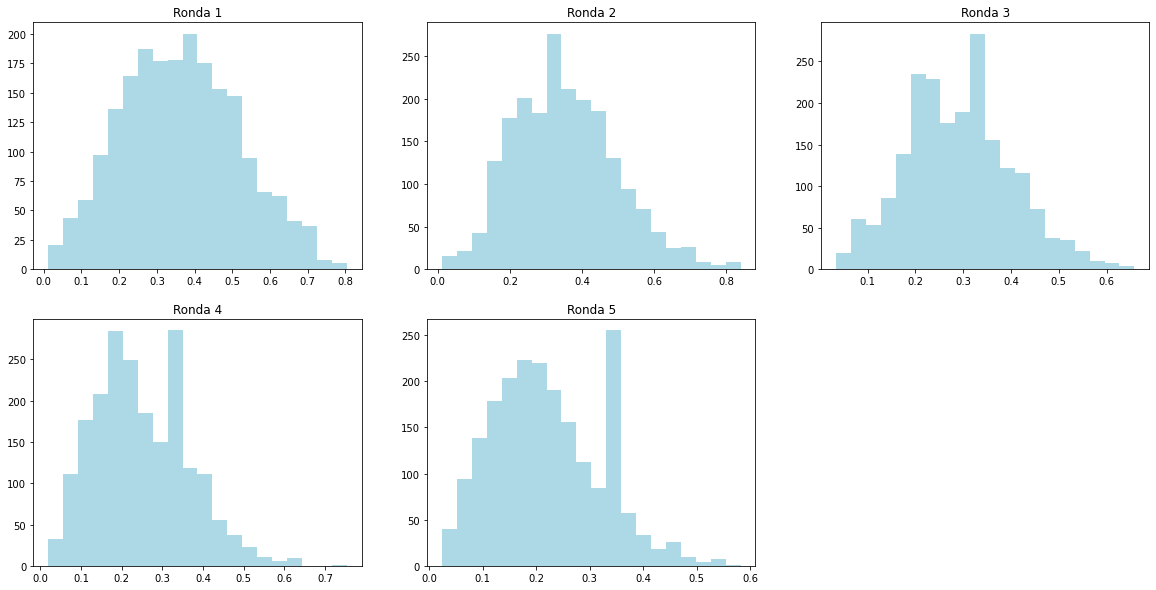

In [10]:
#pltrcParamsupdate({fontsize: 15})

#pltrcParamsupdate({fontsize: 15})
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.hist(r1.risk, bins=20, color='lightblue')
plt.title("Ronda 1")

plt.subplot(2, 3, 2)
plt.hist(r2.risk, bins=20, color='lightblue')
plt.title("Ronda 2")

plt.subplot(2, 3, 3)
plt.hist(r3.risk, bins=20, color='lightblue')
plt.title("Ronda 3")

plt.subplot(2, 3, 4)
plt.hist(r4.risk, bins=20, color='lightblue')
plt.title("Ronda 4")

plt.subplot(2, 3, 5)
plt.hist(r5.risk, bins=20, color='lightblue')
plt.title("Ronda 5")

plt.show()

## Armo el dataset para el entrenamiento
* saco columnas que repiten informacion del target
* separo en X e Y
* estandarizo variables
* relleno los NaN

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Quito variables "administrativas" y variables que repiten información del target
# Por ejemplo índice de masa corporal y el flag the unserweight.

admin = [ 'clustid','childid',"ronda","yc","panel12345","dint","agemon",'careid','dadid','headid','momid']

repeated_info = ["underweight" , "thinness", "drwaterq" , "toiletq" , "elecq" , "cookingq","bmi",
                "zwfa","zhfa","zbfa","zwfl","fwfl","fhfa","fwfa","fbfa","momyrdied","dadyrdied",'hospital','chweight']

dependet = ["risk","risk_cat_1","risk_cat_2",'risk_cat_3',"risk_cat_4",'risk_cat_5']
other = ['placeid']


print(len(admin),
      len(repeated_info),
      len(dependet),
      len(other))



#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

#"levlread", "levlwrit","engrade" , "enrol" refuse to answer. REVISAR.!!!!!!!!!!

cols_to_keep = ["inround",
    'agegr1','aniany','anibeeh','anicowm','anicowt','anidonk','anidrau',
    'anifish','anifshr','anigoat','aniguin','anillam','animilk','aniothr',
    'anioxen','anipigs','anipoul','anirabb','anirumi','anishee','anishri',
    'anisnai','anispec','bcg','beca_yl','birth','birth_age','bonograt','bwdoc',
    'bwght','careage','carecantread','caredu','careladder','caresex','chalcohol',
    'chdisability','chhealth','chhprob','childloc','chillness',
    'chinjury',"chsmoke",'chsex','cladder','commsch','commwork','credit',
    "chrephealth3","chrephealth2","chrephealth1","careldr4yrs",
    'dadcantread','dadedu','dadlive',"dadage",'delivery','dpt',
    "engrade","enrol",
    'female05','female1317','female1860','female61','female612','foodsec',
    'hcare','hchore','headage','headedudu','headsex','hhsize','hib',
    'hplay','hschool','hsleep','hstudy','htask','hwork',
    'insur_yl','juntos',
    'lang_raw',"literate","levlread","levlwrit",
    'male05','male1317','male1860','male61','male612',"marrcohab",'marrcohab_age','maths_raw','measles','minsa_yl',
    'momage','momcantread','momedu','momlive','numante','ownhouse','ownlandhse',
    'polio','ppvt_raw','preprim','projoven_yl',
    'rawscre','reading_raw','rscorelang_cog','rscorelang_ppvt','score_cog',
    'score_ppvt','shcrime1','shcrime2','shcrime3','shcrime4','shcrime5','shcrime6','shcrime8',
    'shecon1','shecon10','shecon11','shecon12','shecon14','shecon2','shecon3','shecon4','shecon5',
    'shecon6','shecon7','shecon8','shecon9','shenv1','shenv10','shenv11','shenv12','shenv2','shenv3',
    'shenv4','shenv5','shenv6','shenv7','shenv8','shenv9','shfam1','shfam10','shfam12','shfam13',
    'shfam14','shfam15','shfam16','shfam17','shfam18','shfam2','shfam3','shfam4','shfam5','shfam6',
    'shfam7','shfam8','shfam9','shhouse1','shhouse2','shhouse3','shother','shregul1','shregul2',
    'shregul4','shregul5','shregul6','sisgrat_yl','sppvt_raw','srawscre',
    'tetanus','typesite',"timesch",
    ( 'headrel',  1.0),( 'headrel',  2.0),( 'headrel',  3.0),( 'headrel',  4.0),( 'headrel',  5.0),
    ( 'headrel',  6.0),( 'headrel',  7.0),( 'carerel',  1.0),( 'carerel',  2.0),( 'carerel',  3.0),
    ( 'carerel',  4.0),( 'carerel',  5.0),( 'carerel',  6.0),( 'carerel',  7.0),('carehead',  1.0),
    ('carehead',  2.0),('carehead',  3.0),(  'entype',  1.0),(  'entype',  2.0),(  'entype',  3.0),
    (  'entype',  4.0),(  'region', 31.0),(  'region', 32.0),(  'region', 33.0),(  'region', 88.0),
               ]


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# separo dataset de predictoras de la variable dependiente

X_r1 = r1.loc[:,cols_to_keep]
#x_train = x_train.loc[:,~(x_train.isnull().values.all(axis=0))] eliminar todas las columnas con null values
y_r1 = r1.risk_cat_1


X_r2 = r2.loc[:,cols_to_keep]
y_r2 = r2.risk_cat_2

X_r3 = r3.loc[:,cols_to_keep]
y_r3 = r3.risk_cat_3

X_r4 = r4.loc[:,cols_to_keep]
y_r4 = r4.risk_cat_4

X_r5 = r5.loc[:,cols_to_keep]
y_r5 = r5.risk_cat_5


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Reemplazo los nulos por cero.  REVISAR.!!!!!!!!!!

X_r1 = X_r1.fillna(0)
X_r2 = X_r2.fillna(0)
X_r3 = X_r3.fillna(0)
X_r4 = X_r4.fillna(0)
X_r5 = X_r5.fillna(0)




11 19 6 1


/Users/NewUser/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [12]:

print('cols_to_keep',len(cols_to_keep),'\n')
#print('still_need_work_to_include',len(still_need_to_work_on),'\n')


cols_to_keep 202 



# Training


In [13]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_r1, y_r2, test_size=0.33, random_state=42)

In [15]:

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Estandarizo dataset de entrenamiento y test por separado

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)

scaler = preprocessing.StandardScaler().fit(X_test)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled)

### Leave One Out

In [ ]:
cut  = 0.7
y_train2 = np.where((y_train >= cut),1,0)
auc_score_test = []
auc_score_train = []
scores = []
d = {}

model_performance = {}

model = LogisticRegression(solver = "liblinear", 
                             penalty = 'l1', 
                             max_iter = 300
                          )
    
loo = LeaveOneOut()
for train_index , test_index in loo.split(X_train_scaled):
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = X_train_scaled.loc[train_index],X_train_scaled.loc[test_index], y_train2[train_index], y_train2[test_index]
    model.fit(X_sub_train,y_sub_train)
    #print("y_sub_test",y_sub_test)
    y_sub_test_pred = model.predict_proba(X_sub_test)[:,1:] 
    y_sub_test_pred = np.where(y_sub_test_pred > 0.5,1,0)
    #print("y_sub_test_pred",y_sub_test_pred)
    score = np.where(y_sub_test_pred == y_sub_test,1,0)
    scores.append(score)
mean_score = sum(scores)/len(scores)
d[str(cut)] = mean_score


In [ ]:
model = LogisticRegression(solver = "liblinear", 
                             penalty = 'l1', 
                             max_iter = 300
                          )

train_and_evaluate(X_train_scaled, y_train, model, cv, splits = None)

In [26]:
def train_and_evaluate_logit(X_train_scaled, y_train, X_test_scaled, y_test ,cut, reg,cv, splits = None):
    
    
    d = {}
    performance = [] 
    it = 0
    
    # for each lambda
    for j in reg:
        start = time.time()
        #print('reg',j)
        model = LogisticRegression(solver = "liblinear", 
                                 penalty = 'l1', 
                                 max_iter = 300,
                                 C = j
                                  )
       # final['reg'] = j
        # for each possible cut
        for i in cut:
            decile  = round((1-i)/0.1)
            y_train2 = np.where((y_train >= decile),1,0)
            y_test2 = np.where((y_test >= decile),1,0)
            #print('cut',i)
            
            # if training with LOO method
            if cv == 'loo':
                scores = []
                loo = LeaveOneOut()
                for train_index , test_index in loo.split(X_train_scaled):
                    X_sub_train, X_sub_test, y_sub_train, y_sub_test = X_train_scaled.loc[train_index],X_train_scaled.loc[test_index], y_train2[train_index], y_train2[test_index]
                    model.fit(X_sub_train,y_sub_train)
                    y_sub_test_proba = model.predict_proba(X_sub_test)[:,1:] 
                    y_sub_test_pred = np.where(y_sub_test_proba > 0.5,1,0)
                    score = np.where(y_sub_test_pred == y_sub_test,1,0)
                    scores.append(score)
                mean_score = float(sum(scores)/len(scores))
                #a[str(i)] = mean_score
                
                # evaluation
                model.fit(X_train_scaled,y_train2)
                test_predictions = model.predict_proba(X_test_scaled)[:,1:]
                train_predictions = model.predict_proba(X_train_scaled)[:,1:]
                
                fpr_log,tpr_log,thr_log = roc_curve(y_test2, test_predictions)
                test_auc = auc(fpr_log, tpr_log)
                fpr_log,tpr_log,thr_log = roc_curve(y_train2, train_predictions)
                train_auc = auc(fpr_log, tpr_log)
            
                #print(j,i,mean_score)
                data = dict(regularization = j,
                                         proportion_class = i, 
                                         mean_score = mean_score,
                                         test_auc =test_auc,
                                         train_auc=train_auc,
                           #              index=[it]
                           )
                #print(data)
                
                performance.append(data)
                #print("regularization:", j, "class balance:", i, "iteration:", it)
                it += 1
   
            # if training with Kfold method
            elif cv == 'kf':
                
                auc_score_test = []
                auc_score_train = []
                d = {}
                for train_index , test_index in kf.split(X_train_scaled):
                    X_sub_train, X_sub_test, y_sub_train, y_sub_test = X_train_scaled.loc[train_index],X_train_scaled.loc[test_index], y_train2[train_index], y_train2[test_index]
                    model.fit(X_sub_train,y_sub_train)
                    y_sub_test_proba = model.predict_proba(X_sub_test)[:,1:]
                    fpr_log, tpr_log, thr_log = roc_curve(y_sub_test, y_sub_test_proba)
                    test_auc = auc(fpr_log, tpr_log)
                    y_sub_train_proba = model.predict_proba(X_sub_train)[:,1:]
                    fpr_log, tpr_log, thr_log = roc_curve(y_sub_train, y_sub_train_proba)
                    train_auc = auc(fpr_log, tpr_log)
                    auc_score_test.append(test_auc)
                    auc_score_train.append(train_auc)
                    print("regularization:", j, "class balance:", i, "iteration:", it)
                b['mean_train_auc'] = sum(auc_score_train)/len(auc_score_train)
                b['std_train_auc'] = (sum([((x - b['mean_train_auc']) ** 2) for x in [1,2,3]]) / len([1,2,3]))**0.5
                b['mean_test_auc'] = sum(auc_score_test)/len(auc_score_test)
                b['std_test_auc'] = (sum([((x - b['mean_test_auc']) ** 2) for x in [1,2,3]]) / len([1,2,3]))**0.5
                a[str(i)] = b
            
            
            print("finish time", time.time() - start)
    return performance


In [36]:
results = train_and_evaluate_logit(X_train_scaled,
                                   y_train, 
                                   X_test_scaled,
                                   y_test,
                                   [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                                   [0.01,0.1,1,5],
                                   'loo')

print(results[0])

results_df = pd.json_normalize(results)

In [47]:
results_df.sort_values(by=['test_auc'],ascending=False)

,regularization,proportion_class,mean_score,test_auc,train_auc,index
17,0.100,0.900,0.903,0.859,0.865,[17]
15,0.100,0.700,0.778,0.853,0.866,[15]
16,0.100,0.800,0.808,0.849,0.857,[16]
13,0.100,0.500,0.781,0.845,0.856,[13]
24,1.000,0.700,0.763,0.844,0.873,[24]
14,0.100,0.600,0.782,0.843,0.881,[14]
33,5.000,0.700,0.761,0.843,0.873,[33]
23,1.000,0.600,0.779,0.841,0.886,[23]
32,5.000,0.600,0.777,0.841,0.887,[32]
25,1.000,0.800,0.797,0.840,0.866,[25]


## KFold

In [ ]:
model_performance = {}

model = LogisticRegression(solver = "liblinear", 
                             penalty = 'l1', 
                             max_iter = 300
                          )

kf = KFold(n_splits = 5)
it = 0

for i in [0.1, 0.2, 0.3, 0.5]:
    cut  = round((1-i)/0.1)
    y_train2 = np.where((y_train >= cut),1,0)
    it += 1
    auc_score_test = []
    auc_score_train = []
    d = {}
    for train_index , test_index in kf.split(X_train_scaled):
        X_sub_train, X_sub_test, y_sub_train, y_sub_test = X_train_scaled.loc[train_index],X_train_scaled.loc[test_index], y_train2[train_index], y_train2[test_index]
        model.fit(X_sub_train,y_sub_train)
        y_sub_test_pred = model.predict_proba(X_sub_test)[:,1:]
        fpr_log, tpr_log, thr_log = roc_curve(y_sub_test, y_sub_test_pred)
        test_auc = auc(fpr_log, tpr_log)
        
        y_sub_train_pred = model.predict_proba(X_sub_train)[:,1:]
        fpr_log, tpr_log, thr_log = roc_curve(y_sub_train, y_sub_train_pred)
        train_auc = auc(fpr_log, tpr_log)
        
        
        auc_score_test.append(test_auc)
        auc_score_train.append(train_auc)
        
    d['mean_train_auc'] = sum(auc_score_train)/len(auc_score_train)
    d['std_train_auc'] = (sum([((x - d['mean_train_auc']) ** 2) for x in [1,2,3]]) / len([1,2,3]))**0.5
    d['mean_test_auc'] = sum(auc_score_test)/len(auc_score_test)
    d['std_test_auc'] = (sum([((x - d['mean_test_auc']) ** 2) for x in [1,2,3]]) / len([1,2,3]))**0.5
    
    model_performance[str(cut)] = d
    
    

In [ ]:
prop = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
logit = LogisticRegressionCV(solver = "liblinear", 
                             penalty = 'l1', 
                             max_iter = 300, 
                             cv = 3#LeaveOneOut()
                          )
groups = 10

results = train_and_evaluate(prop, logit, X_train_scaled, y_train,X_test_scaled, y_test )
results

## Entrenamiento del modelo final - Ronda 1 vs Ronda 2

In [ ]:
y_train = np.where((y_train >= 7),1,0)
y_test = np.where((y_test >= 7),1,0)

### Fine tunning

In [ ]:
'''this cell is ment to help choosing regularization parameter lambda for l1 penalty'''
'''
grid={"C":[10, 1, .1, .01, 0.001], 
      "penalty":["l1","l2"], 
      "solver":["liblinear"],  
      "max_iter":[100,500]}# l1 lasso l2 ridge

logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv = LeaveOneOut(), return_train_score = True)
logreg_cv.fit(X_r1_scaled, y_r2)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

results = pd.DataFrame(logreg_cv.cv_results_)
results["overfit"] = results.mean_train_score - results.mean_test_score 

print(results.loc[results.rank_test_score == 1,"overfit"])
#results.sort_values(by = 'rank_test_score')'''

### Training

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Final Model Training



logit_cv = LogisticRegressionCV(solver = "liblinear", 
                               penalty = 'l1', 
                               cv = LeaveOneOut(), 
                               Cs = [0.01], 
                               fit_intercept=True)


logit_cv.fit(X_train_scaled, y_train)


In [ ]:
# predigo probabilidades
y_test_prob = logit_cv.predict_proba(X_test_scaled)[:,1:]
y_train_prob = logit_cv.predict_proba(X_train_scaled)[:,1:]

### Metricas de Performance

In [ ]:
roc_curve_plot(y_train, y_train_prob, 'train')

In [ ]:
roc_curve_plot(y_test, y_test_prob, 'test')

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Comparo contra un clasificador Dummy

dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train_scaled, y_train)
y_dummy_predictions = dummy_majority.predict(X_test_scaled)
dummy_majority.score(X_test_scaled, y_test)

In [ ]:
#basandome en la curva roc elijo punto de corte
y_test_pred = label_observation(y_test_prob, 0.3, 'binary')
confusion_matrix = confusion_matrix(np.array(y_test), y_test_pred)
print(confusion_matrix)

In [ ]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_test_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_test_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_test_pred)))
print('F1: {:.2f}'.format(f1_score(y_test, y_test_pred)))

In [ ]:
print(classification_report(y_test, y_test_pred, target_names=['0', '1']))

#### Interpretación

In [ ]:
coef_dict = {}
for coef, feat in zip(logit_cv.coef_[0,:],X_r1.columns):
    coef_dict[feat] = coef
    
coef_dict
dict(sorted(coef_dict.items(), key=lambda item: item[1]))

In [ ]:

risk_per_round = pd.merge(r1.loc[:,["childid","risk_cat_1"]], 
                          r2.loc[:,["childid","risk_cat_2"]],
                          how="inner",
                          on = ["childid"])

risk_per_round = pd.merge(risk_per_round, 
                          r3.loc[:,["childid","risk_cat_3"]],
                          how="inner",
                          on = ["childid"])

In [ ]:
risk_per_round.head()

In [ ]:
risk_per_round = pd.concat([risk_per_round.reset_index(drop=True),
                      pd.DataFrame(y_r3_prob, columns = ['y_r3_prob']),
                     pd.DataFrame(y_r3_pred, columns = ['y_r3_pred'])],
                     axis = 1)
risk_per_round.head()

In [ ]:
baja_categoria_12 = risk_per_round[risk_per_round.risk_cat_1 < risk_per_round.risk_cat_2]
sube_categoria_12 = risk_per_round[risk_per_round.risk_cat_1 > risk_per_round.risk_cat_2]
print(sube_categoria_12.shape,baja_categoria_12.shape)

baja_categoria_23 = risk_per_round[risk_per_round.risk_cat_2 < risk_per_round.risk_cat_3]
sube_categoria_23 = risk_per_round[risk_per_round.risk_cat_2 > risk_per_round.risk_cat_3]
print(sube_categoria_23.shape, baja_categoria_23.shape)

In [ ]:
r1[r1["childid"].isin(sube_categoria_12["childid"])]

In [ ]:
r1[r1["childid"].isin(baja_categoria_12["childid"])]

In [ ]:
risk_per_round["groups"] = pd.qcut(risk_per_round["y_r3_prob"] , 5,labels = False)
risk_per_round.groupby(["groups"]).agg({"y_r3_prob":["count","min","mean","max"],
                                        #"risk_cat_1" : ["mean"],
                                        #"risk_cat_2" : ["mean"],
                                        "risk_cat_3" : ["mean"]})

In [ ]:
df_preds = pd.merge(r2,
                    risk_per_round.loc[:,["childid","risk_cat_3"]],
                    how="inner",
                    on = ["childid"])

In [ ]:



feature_importance = df_preds.groupby(['risk_cat_3']).agg({"momedu":["mean"],
                                                           "delivery":["mean"],
                                                           "agegr1":["mean"],
                                                           "bwght":["mean"],
                                                           "aniany":["mean"],
                                                           "typesite":["mean"],
                                                           ('region', 31.0):["mean"]})

feature_importance.columns = ['momedu','delivery',"agegr1","bwght","aniany","typesite",'region_31']


feature_importance = feature_importance.reset_index()

In [ ]:
#pltrcParamsupdate({fontsize: 15})

#['momedu','carehead','female1860','measles',"headrel","dadage"]
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
x = feature_importance.risk_cat_3
y = feature_importance.momedu
plt.bar(x, y)
plt.title("momedu")

plt.subplot(2, 3, 2)
x = feature_importance.risk_cat_3
y = feature_importance.delivery
plt.bar(x, y)
plt.title("delivery")

plt.subplot(2, 3, 3)
x = feature_importance.risk_cat_3
y = feature_importance.agegr1
plt.bar(x, y)
plt.title("agegr1")

plt.subplot(2, 3, 4)
x = feature_importance.risk_cat_3
y = feature_importance.region_31
plt.bar(x, y)
plt.title("region_31")

plt.subplot(2, 3, 5)
x = feature_importance.risk_cat_3
y = feature_importance.bwght
plt.bar(x, y)
plt.title("bwght")

plt.subplot(2, 3, 6)
x = feature_importance.risk_cat_3
y = feature_importance.aniany
plt.bar(x, y)
plt.title("aniany")


plt.show()

In [ ]:
'''C = [500,25,10, 1, .1, .001]
reg = ['l1','l2']
CV = [5,10]

for penalty in reg:
    for cv in CV:
        for c in C:
            print(penalty, cv, c)
            logit_l1 = LogisticRegressionCV(penalty=penalty, Cs=[c], solver='liblinear', cv=cv)
            logit_l1.fit(X_r1_scaled, y_r2)
            print('C:', c)
            #print('Coefficient of each feature:', logit_l1.coef_)
            print('Training accuracy:', logit_l1.score(X_r1_scaled, y_r2))
            print('Test accuracy:', logit_l1.score(X_r2_scaled, y_r3))
            print('')
   
# https://chrisalbon.com/code/machine_learning/logistic_regression/logistic_regression_with_l1_regularization/

'''

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Gridsearch
'''
grid = {"Cs":[10, 1, .1, 0.001], 
      "penalty":["l1","l2"], 
      "solver":["liblinear"],  
      "cv":[3,5,10],
      "max_iter":[10000]}

logreg = LogisticRegressionCV()
logreg_cv = GridSearchCV(logreg,grid,return_train_score = True)
logreg_cv.fit(X_r1_scaled,y_r2)

print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_ )
print("accuracy :",logreg_cv.best_score_)

results = pd.DataFrame(logreg_cv.cv_results_)
results["overfit"] = results.mean_train_score - results.mean_test_score '''